# **download data**

In [ ]:
import pandas as pd
import numpy as np
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/lih627/CamVid.git

In [ ]:
path = '/content/drive/MyDrive/CamVid/'
image_path = path + 'camvid_trainval.txt'
mask_path = path + 'CamVidGray'
color_mask_path = path + 'CamVidColor11'

image_list = []
mask_list = []
test_image = []
test_mask = []

base_path = '/content/drive/MyDrive/CamVid/'
txt_file = base_path + 'camvid_trainval.txt'
test_text_file = base_path + 'camvid_test.txt'

# separate trainval mask paths and image paths
with open(txt_file, 'r') as f:
    for line in f:
        line = line.strip()
        if line == "":
            continue
        image_rel_path, mask_rel_path = line.split()
        image_full_path = base_path + image_rel_path
        mask_full_path = base_path + mask_rel_path
        image_list.append(image_full_path)
        mask_list.append(mask_full_path)

# separate mask paths and image paths in test data
with open(test_text_file, 'r') as f:
    for line in f:
        line = line.strip()
        if line == "":
            continue
        image_rel_path, mask_rel_path = line.split()
        image_full_path = base_path + image_rel_path
        mask_full_path = base_path + mask_rel_path
        test_image.append(image_full_path)
        test_mask.append(mask_full_path)


In [ ]:
print(image_list[:5])
print(mask_list[:5])
print(test_image[100:105])
print(test_mask[100:105])

['/content/drive/MyDrive/CamVid/CamVid_RGB/0001TP_006690.png', '/content/drive/MyDrive/CamVid/CamVid_RGB/0001TP_006720.png', '/content/drive/MyDrive/CamVid/CamVid_RGB/0001TP_006750.png', '/content/drive/MyDrive/CamVid/CamVid_RGB/0001TP_006780.png', '/content/drive/MyDrive/CamVid/CamVid_RGB/0001TP_006810.png']
['/content/drive/MyDrive/CamVid/CamVidGray/0001TP_006690_L.png', '/content/drive/MyDrive/CamVid/CamVidGray/0001TP_006720_L.png', '/content/drive/MyDrive/CamVid/CamVidGray/0001TP_006750_L.png', '/content/drive/MyDrive/CamVid/CamVidGray/0001TP_006780_L.png', '/content/drive/MyDrive/CamVid/CamVidGray/0001TP_006810_L.png']
['/content/drive/MyDrive/CamVid/CamVid_RGB/Seq05VD_f01140.png', '/content/drive/MyDrive/CamVid/CamVid_RGB/Seq05VD_f01170.png', '/content/drive/MyDrive/CamVid/CamVid_RGB/Seq05VD_f01200.png', '/content/drive/MyDrive/CamVid/CamVid_RGB/Seq05VD_f01230.png', '/content/drive/MyDrive/CamVid/CamVid_RGB/Seq05VD_f01260.png']
['/content/drive/MyDrive/CamVid/CamVidGray/Seq05VD_f

In [ ]:
print("number of train data: ",len(image_list))

print("number of test data: ",len(test_image))


number of train data:  468
number of test data:  233


# **show sample data**

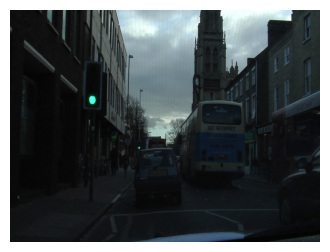

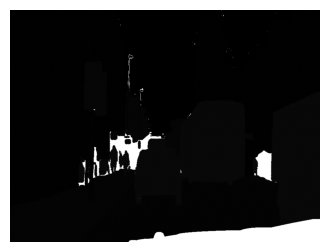

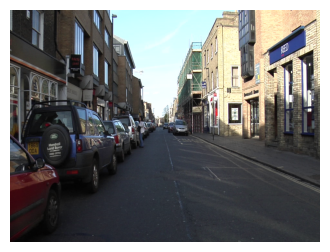

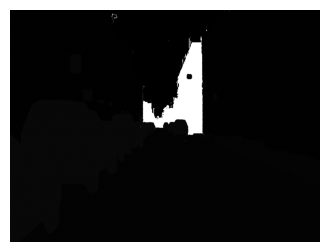

In [ ]:
#show images
from PIL import Image
import matplotlib.pyplot as plt
def show(path):
  img=Image.open(path)
  plt.figure(figsize=(4,4))
  plt.imshow(img,cmap='gray')
  plt.grid(False)
  plt.axis('off')
  plt.show()


show(image_list[1])
show(mask_list[1])

show(image_list[300])
show(mask_list[300])

# **define metrics**

In [ ]:
#dice metric
def dice_metric(pred,target,epsilon=1e-5):
  pred = pred.float()
  target = target.float()
  intersection = (pred * target).sum()
  union = pred.sum() + target.sum()
  dice = (2. * intersection + epsilon) / (union + epsilon)
  return dice
#iou metric
def iou_metric(pred,target,epsilon=1e-5):
    pred = pred.astype(np.float32)
    target = target.astype(np.float32)
    intersection = np.sum(pred * target)
    union = np.sum(pred) + np.sum(target) - intersection
    iou = (intersection + epsilon) / (union + epsilon)
    return iou


In [ ]:
sample_path = image_list[300]
from PIL import Image
sample = Image.open(sample_path)
print(sample.size)


(960, 720)


# **preproccecing**

In [ ]:
#data shape is (960,720)
#define models
import cv2
def standardize(x):
    x = np.array(x, dtype='float64')
    x -= np.min(x)
    x /= np.percentile(x, 98)
    x[x > 1] = 1
    return x
def preprocessing(img):
    image = np.array(img)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    image = np.zeros_like(image)
    image[:,:,0] = gray
    image[:,:,1] = gray
    image[:,:,2] = gray
    image = standardize(image)
    return image



In [ ]:
label_mapping = {
    0: 0,
    1: 1,
    2: 2,
    3: 3,
    4: 4,
    5: 5,
    6: 6,
    7: 7,
    8: 8,
    9: 9,
    10: 10
}

def relabel_mask(mask):
    relabeled = np.copy(mask)
    for old_val, new_val in label_mapping.items():
        relabeled[mask == old_val] = new_val
    return relabeled


In [ ]:
import cv2
import tqdm
train_images = []
train_masks = []
x = 1024
y = 512
n_classes = 11

for imgpath in tqdm.tqdm(image_list):
    img = cv2.imread(imgpath)
    img = cv2.resize(img, (x, y))
    img = preprocessing(img)
    train_images.append(img)

for maskpath in tqdm.tqdm(mask_list):
    mask = cv2.imread(maskpath, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (x, y), interpolation=cv2.INTER_NEAREST)
    mask = relabel_mask(mask)
    train_masks.append(mask)


train_images = np.array(train_images)
train_masks = np.array(train_masks)

100%|██████████| 468/468 [01:31<00:00,  5.13it/s]


In [ ]:
np.save('/content/drive/MyDrive/MyFolder/train_images.npy', train_images)
np.save('/content/drive/MyDrive/MyFolder/train_masks.npy', train_masks)


In [ ]:
import tqdm

test_images = []
test_masks = []
x = 1024
y = 512

for imgpath in tqdm.tqdm(test_image):
    img = cv2.imread(imgpath)
    img = cv2.resize(img, (x, y))
    img = preprocessing(img)
    test_images.append(img)

for maskpath in tqdm.tqdm(test_mask):
    mask = cv2.imread(maskpath, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (x, y), interpolation=cv2.INTER_NEAREST)
    mask = relabel_mask(mask)
    test_masks.append(mask)

test_images = np.array(test_images)
test_masks = np.array(test_masks)


100%|██████████| 233/233 [01:50<00:00,  2.11it/s]


In [ ]:
np.save('/content/drive/MyDrive/MyFolder/test_images.npy', test_images)
np.save('/content/drive/MyDrive/MyFolder/test_masks.npy', test_masks)


In [ ]:
path='/content/drive/MyDrive/MyFolder'
train_images=np.load(path+'/train_images.npy')
train_masks=np.load(path+'/train_masks.npy')
test_images[2].shape

(1024, 1024, 3)

# **define model**

In [ ]:
import tensorflow
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Dropout
from tensorflow.keras.layers import SeparableConv2D,DepthwiseConv2D,ReLU,Activation
from tensorflow.keras.layers import Add,GlobalAveragePooling2D,Concatenate,AveragePooling2D


#botleneck
def expansion_layer(x, in_channels, t):
    new_channels = in_channels * t
    x = Conv2D(filters=new_channels, kernel_size=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

def depthwise_layer(x, stride):
    x = DepthwiseConv2D(kernel_size=3, strides=stride, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

def projection_layer(x, out_channels):
    x = Conv2D(filters=out_channels, kernel_size=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    return x
#final
def bottleneck(x, in_channels, out_channels, t, stride):

    shortcut = x

    x = expansion_layer(x, in_channels, t)
    x = depthwise_layer(x, stride)
    x = projection_layer(x, out_channels)

    if in_channels == out_channels and stride == 1:
        x = Add()([shortcut, x])
    return x
#ppm layer

def ppm_layer(input_tensor, out_channels=128):
    h, w = input_tensor.shape[1], input_tensor.shape[2]

    pool_sizes = [1, 2, 3, 6]
    pooled_outputs = []

    for size in pool_sizes:
        x = AveragePooling2D(pool_size=(size, size), strides=(size, size), padding='same')(input_tensor)
        x = Conv2D(out_channels // 4, kernel_size=1, padding='same', use_bias=False)(x)
        x = ReLU()(x)
        x = UpSampling2D(size=(h // x.shape[1], w // x.shape[2]), interpolation='bilinear')(x)
        pooled_outputs.append(x)

    pooled_outputs.append(input_tensor)
    concat = Concatenate(axis=-1)(pooled_outputs)
    out = Conv2D(out_channels, kernel_size=1, padding='same', use_bias=False)(concat)
    out = ReLU()(out)
    return out


#learning down to sample
input=Input(shape=(512,512,3))
x1=Conv2D(filters=32, kernel_size=3, strides=2, padding='same', use_bias=False, activation='relu')(input)
x2=SeparableConv2D(filters=48, kernel_size=3, strides=2, padding='same', use_bias=False, activation='relu')(x1)
x3=SeparableConv2D(filters=64, kernel_size=3, strides=2, padding='same', use_bias=False, activation='relu')(x2)

#global feature extractor
y1=bottleneck(x3,64,64,6,2)
y2=bottleneck(y1,64,64,6,2)
y3=bottleneck(y2,64,64,6,2)
#secound_block
z1=bottleneck(y3,64,96,6,2)
z2=bottleneck(z1,64,96,6,2)
z3=bottleneck(z2,64,96,6,2)
#third_block
w1=bottleneck(z3,96,128,6,1)
w2=bottleneck(w1,96,128,6,1)
w3=bottleneck(w2,96,128,6,1)
#ppm
final = ppm_layer(w3)

#feature fusion block
m=UpSampling2D(size=(4, 4), interpolation='bilinear')(final )
m=DepthwiseConv2D(kernel_size=3, padding='same', use_bias=False)(m)
m=BatchNormalization()(m)
m=ReLU()(m)
m=Conv2D(128, kernel_size=1, padding='same', use_bias=False)(m)
m=BatchNormalization()(m)
m = UpSampling2D(size=(16, 16), interpolation='bilinear')(m)

#second path
p=Conv2D(128, kernel_size=1, padding='same', use_bias=False)(x3)
p=BatchNormalization()(p)
#concatenate two parts
output= Add()([m,p])
output = ReLU()(output)

#classification block
c1=DepthwiseConv2D(kernel_size=3, padding='same', use_bias=False,strides=1)(output)
c2=DepthwiseConv2D(kernel_size=3, padding='same', use_bias=False,strides=1)(c1)
c3=Conv2D(19, kernel_size=1, padding='same', use_bias=False,strides=1)(c2)
c4 = UpSampling2D(size=(8, 8), interpolation='bilinear')(c3)
output = Activation('softmax')(c4)

model = Model(inputs=input, outputs=c4)













In [ ]:
import tensorflow as tf
def multiclass_iou(y_true, y_pred, smooth=1e-5):
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, tf.int32)

    y_true = tf.one_hot(y_true, depth=19)
    y_pred = tf.one_hot(y_pred, depth=19)

    intersection = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    union = tf.reduce_sum(tf.cast(y_true + y_pred, tf.float32)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou


def multiclass_dice(y_true, y_pred, smooth=1e-5):
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=19)  # adjust depth
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
    y_pred = tf.one_hot(tf.argmax(y_pred, axis=-1), depth=19)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice


# **train model**

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', multiclass_dice, multiclass_iou]
)



In [ ]:
model.fit(
      train,
    mosks,
    batch_size=2,
    epochs=5,
    validation_split=0.1
)

Epoch 1/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 233s 1s/step - accuracy: 0.5379 - loss: 1.7957 - multiclass_dice: 0.5379 - multiclass_iou: 0.3715 - val_accuracy: 0.6002 - val_loss: 1.8688 - val_multiclass_dice: 0.6009 - val_multiclass_iou: 0.4299
Epoch 2/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - accuracy: 0.6190 - loss: 1.2350 - multiclass_dice: 0.6190 - multiclass_iou: 0.4506 - val_accuracy: 0.5742 - val_loss: 1.2794 - val_multiclass_dice: 0.5747 - val_multiclass_iou: 0.4034
Epoch 3/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step - accuracy: 0.6283 - loss: 1.1304 - multiclass_dice: 0.6283 - multiclass_iou: 0.4610 - val_accuracy: 0.5818 - val_loss: 1.4494 - val_multiclass_dice: 0.5823 - val_multiclass_iou: 0.4109
Epoch 4/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - accuracy: 0.6415 - loss: 1.1263 - multiclass_dice: 0.6415 - multiclass_iou: 0.4762 - val_accuracy: 0.5376 - val_loss: 2.5245 - val_multiclass_dice: 0.4946 - val_multiclass_iou: 0.3697
Epoch 5/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/s

In [ ]:
model.fit(
    train,
    mosks,
    batch_size=5,
    epochs=8,
    initial_epoch=5,
    validation_split=0.1
)

Epoch 6/8
85/85 ━━━━━━━━━━━━━━━━━━━━ 240s 3s/step - accuracy: 0.6552 - loss: 1.0253 - multiclass_dice: 0.6552 - multiclass_iou: 0.4884 - val_accuracy: 0.5907 - val_loss: 1.2198 - val_multiclass_dice: 0.5923 - val_multiclass_iou: 0.4210
Epoch 7/8
85/85 ━━━━━━━━━━━━━━━━━━━━ 237s 3s/step - accuracy: 0.6606 - loss: 0.9925 - multiclass_dice: 0.6606 - multiclass_iou: 0.4943 - val_accuracy: 0.5906 - val_loss: 1.2028 - val_multiclass_dice: 0.5915 - val_multiclass_iou: 0.4202
Epoch 8/8
85/85 ━━━━━━━━━━━━━━━━━━━━ 237s 3s/step - accuracy: 0.6657 - loss: 0.9862 - multiclass_dice: 0.6657 - multiclass_iou: 0.5008 - val_accuracy: 0.5961 - val_loss: 1.0901 - val_multiclass_dice: 0.5970 - val_multiclass_iou: 0.4257


In [ ]:
model.save('/content/drive/MyDrive/model/my_model.h5')

# **show results**

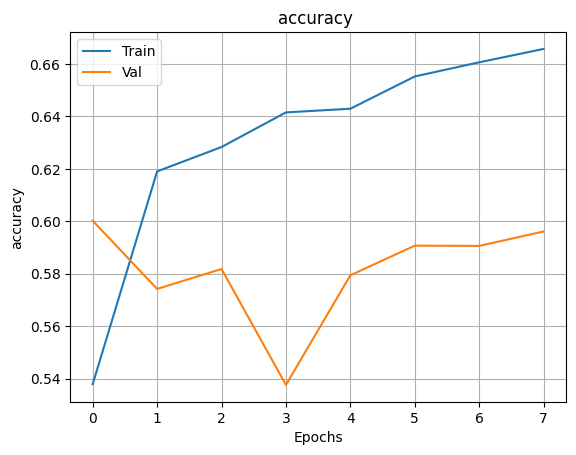

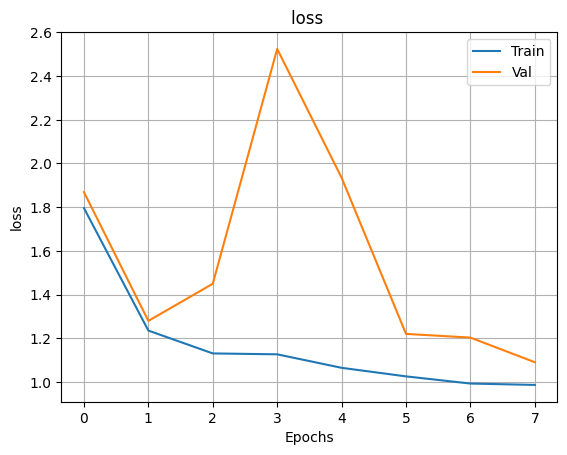

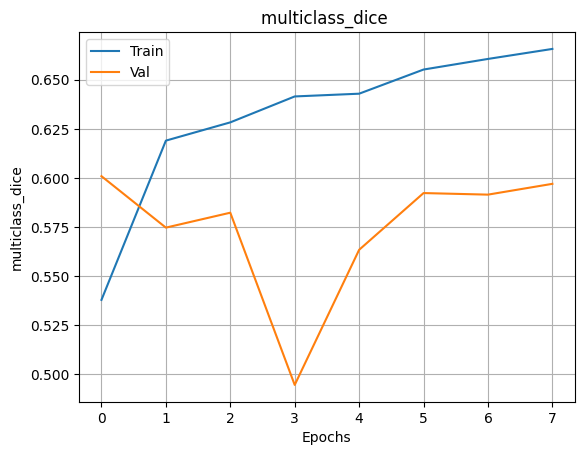

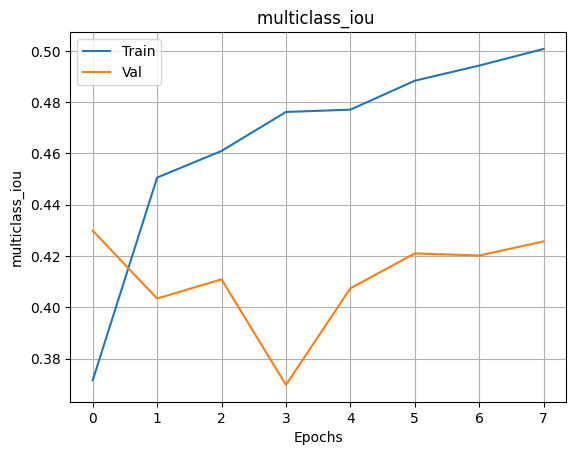

In [ ]:
import matplotlib.pyplot as plt
history = {
    'accuracy': [0.5379, 0.6190, 0.6283, 0.6415, 0.6429, 0.6552, 0.6606, 0.6657],
    'val_accuracy': [0.6002, 0.5742, 0.5818, 0.5376, 0.5794, 0.5907, 0.5906, 0.5961],
    'loss': [1.7957, 1.2350, 1.1304, 1.1263, 1.0645, 1.0253, 0.9925, 0.9862],
    'val_loss': [1.8688, 1.2794, 1.4494, 2.5245, 1.9347, 1.2198, 1.2028, 1.0901],
    'multiclass_dice': [0.5379, 0.6190, 0.6283, 0.6415, 0.6429, 0.6552, 0.6606, 0.6657],
    'val_multiclass_dice': [0.6009, 0.5747, 0.5823, 0.4946, 0.5634, 0.5923, 0.5915, 0.5970],
    'multiclass_iou': [0.3715, 0.4506, 0.4610, 0.4762, 0.4771, 0.4884, 0.4943, 0.5008],
    'val_multiclass_iou': [0.4299, 0.4034, 0.4109, 0.3697, 0.4074, 0.4210, 0.4202, 0.4257]
}
metrics = [
    ('accuracy', 'val_accuracy'),
    ('loss', 'val_loss'),
    ('multiclass_dice', 'val_multiclass_dice'),
    ('multiclass_iou', 'val_multiclass_iou')
]
for train_metric, val_metric in metrics:
    plt.figure()
    plt.plot(history[train_metric], label='Train')
    plt.plot(history[val_metric], label='Val')
    plt.title(f'{train_metric} ')
    plt.xlabel('Epochs')
    plt.ylabel(train_metric)
    plt.legend()
    plt.grid(True)
    plt.show()

# **evaluate on test data**

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/model/my_model.h5')


In [ ]:
model = keras.models.load_model(
    '/content/drive/MyDrive/model/my_model.h5',
    custom_objects={
        'multiclass_dice': multiclass_dice,
        'multiclass_iou': multiclass_iou
    }
)

In [ ]:
path='/content/drive/MyDrive/test_images.npy'
test=np.load(path)

In [ ]:
path='/content/drive/MyDrive/test_masks.npy'
test_masks=np.load(path)

In [ ]:
test_masks = np.where(test_masks == 255, 0, test_masks)

In [ ]:
history=model.evaluate(test,test_masks)

8/8 ━━━━━━━━━━━━━━━━━━━━ 72s 9s/step - accuracy: 0.5713 - loss: 1.4223 - multiclass_dice: 0.5722 - multiclass_iou: 0.4078


# **show samples**

In [ ]:
for layer in model.layers:
    layer.trainable = False

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


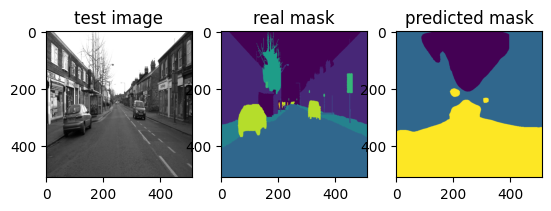

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


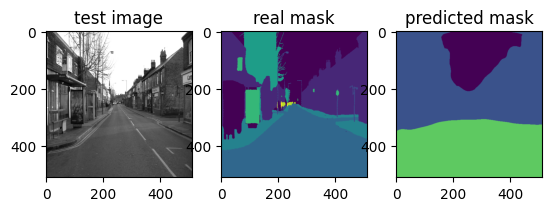

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


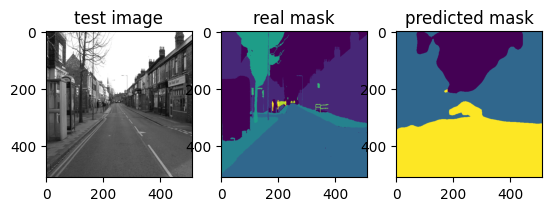

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


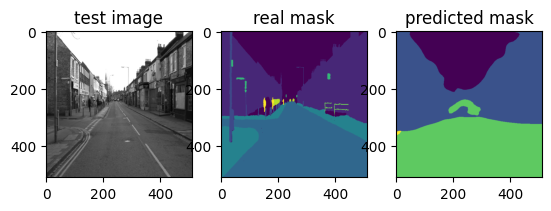

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


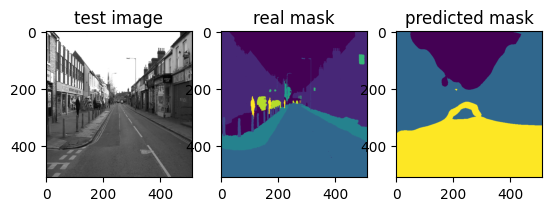

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


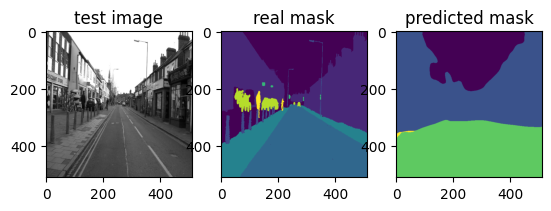

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


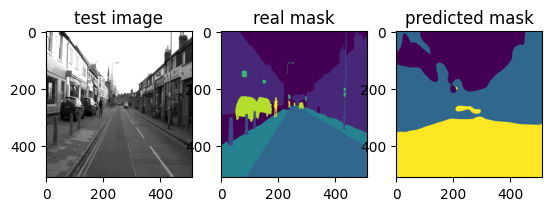

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


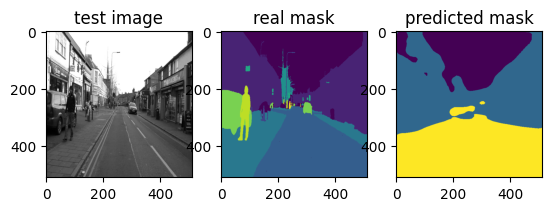

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


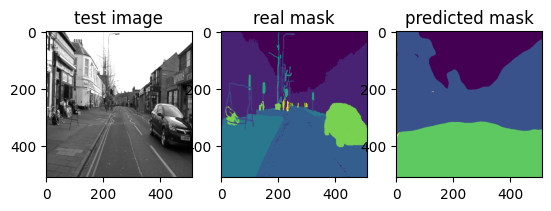

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


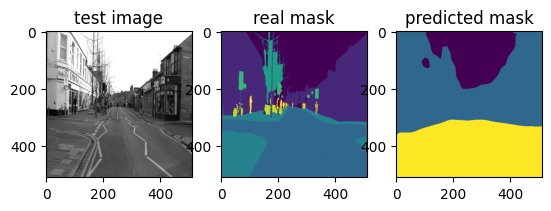

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(200,210):
    image = test[i:i+1]
    msk = test_masks[i]
    pred = model.predict(image)
    pred_mask = np.argmax(pred, axis=-1)[0]
    plt.subplot(1, 3, 1)
    plt.imshow(image[0])
    plt.title('test image')

    plt.subplot(1, 3, 2)
    plt.imshow(msk)
    plt.title('real mask')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask)
    plt.title('predicted mask')

    plt.show()


In [ ]:
y_true_all = []
y_pred_all = []

for i in range(len(test)):
    image = test[i]
    true_mask = test_masks[i]

    pred = model.predict(image[None, ...])
    pred_mask = np.argmax(pred[0], axis=-1)

    y_true_all.append(true_mask)
    y_pred_all.append(pred_mask)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_true_flat = np.array(y_true_all).flatten()
y_pred_flat = np.array(y_pred_all).flatten()

num_classes = 10
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat, labels=list(range(num_classes)))

conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1, keepdims=True)


per_class_acc = np.diag(conf_matrix) / conf_matrix.sum(axis=1)

for i, acc in enumerate(per_class_acc):
    print(f"accuracy {i} : {acc:.4f}")



accuracy 0 : 0.7467
accuracy 1 : 0.9317
accuracy 2 : 0.0000
accuracy 3 : 0.9483
accuracy 4 : 0.0054
accuracy 5 : 0.0002
accuracy 6 : 0.0000
accuracy 7 : 0.0000
accuracy 8 : 0.0000
accuracy 9 : 0.0000
